## DEFINE

### ---- Define the problem ----

One of our clients, a wine manufacturer, is looking to gain insights into the kind of wine that gets the best reception from critics. Your job is to dig into a dataset of reviews from Wine Enthusiast to provide these insights to an executive at this company. 

In [1]:
__author__ = "Arielle Dortch"
__email__ = "arielledortch@gmail.com"
##Packages Needed for Initial Exploration
import pandas as pd  # DataFrame structure and operations
import numpy as np  # arrays and numerical processing
import matplotlib.pyplot as plt  # 2D plotting
import statsmodels.api as sm  # logistic regression
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING

## DISCOVER

### ----  Load the data ----

In [2]:
##Read in csv. Explore Dataset
wine = pd.read_csv("/Users/arielledortch/Downloads/winemag-data-130k-v2.csv")
print(wine.head())

   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

### ----EDA ----

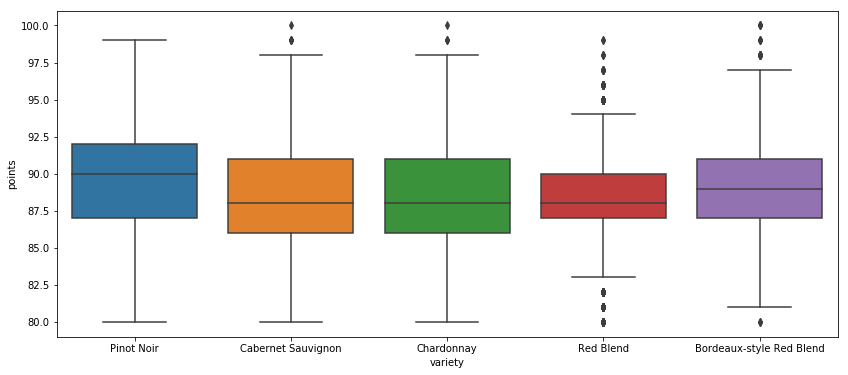

In [3]:
## Q1- Which wine varieties typically received the most points?
df = wine[wine.variety.isin(wine.variety.value_counts().head(5).index)]
plt.figure(figsize= (14,6))
sns.boxplot(
    x='variety',
    y='points',
    data=df
)

0                                          Nicosia
1                              Quinta dos Avidagos
2                                        Rainstorm
3                                       St. Julian
4                                     Sweet Cheeks
5                                           Tandem
6                                  Terre di Giurfo
7                                         Trimbach
8                                      Heinz Eifel
9                               Jean-Baptiste Adam
10                              Kirkland Signature
11                                      Leon Beyer
12                                Louis M. Martini
13                             Masseria Setteporte
14                                        Mirassou
15                                 Richard Böcking
16                                   Felix Lavaque
17                                   Gaucho Andino
18                                        Pradorey
19                             

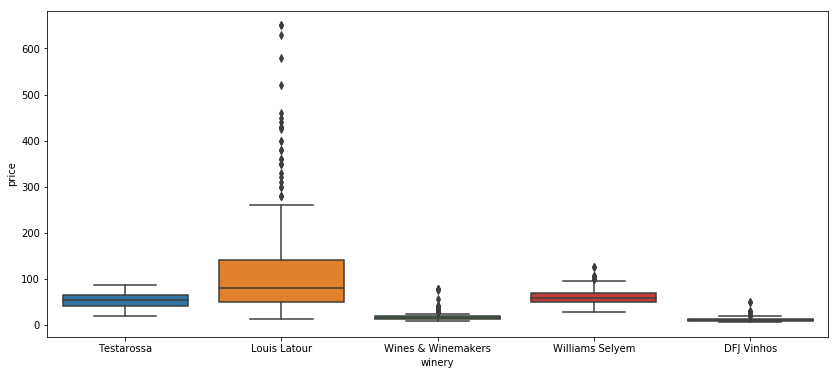

In [4]:
#Q.2 Which wineries produced the priciest wines? Is there any correlation between price and points?

#Explore Wineries 
print(wine['winery'])

##Winery by Price Boxplot
df2 = wine[wine.winery.isin(wine.winery.value_counts().head(5).index)]

plt.figure(figsize= (14,6))
sns.boxplot(
    x='winery',
    y='price',
    data=df2
)


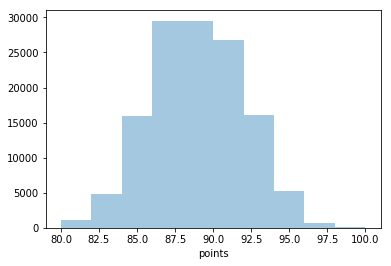

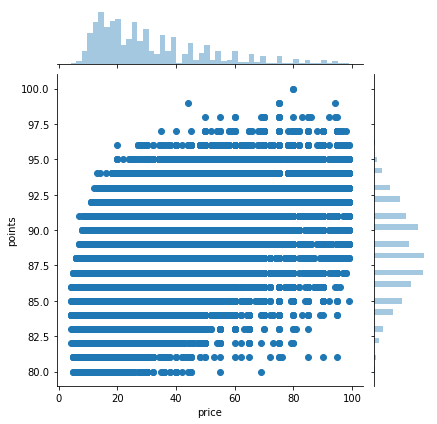

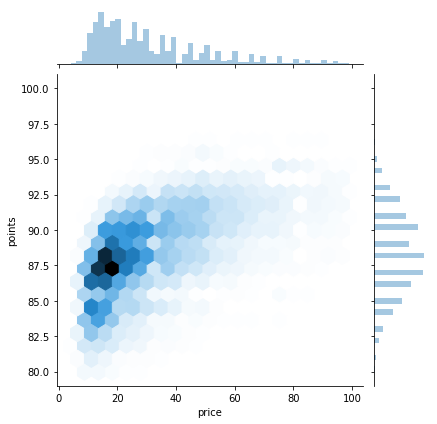

In [15]:
#Q2 Part 2-Is there any correlation between price and points?

##Provide the descriptive statistics of points and price
wine.describe()
##Histogram to determine distribution of points. Range of points 80-100
sns.distplot(wine['points'], bins=10, kde=False)

##Create Scatterplot for price and points
sns.jointplot(x='price', y='points', data=wine[wine['price'] < 100])

##Use hex plot to determine strength of correlation. 
sns.jointplot(x='price', y='points', data=wine[wine['price'] < 100], kind='hex', 
              gridsize=20)



## TOPIC MODELING

In [58]:
##Bonus Question: What topics do the wine descriptions fall under? (Hint: Use a topic modeling algorithm like Latent Dirichlet allocation on the description column)
##The remainder of this notebook describes all of the steps taken to create the LDA visualization in the last chunk of code.  
##Packages needed for Topic Analysis
from tqdm import tqdm
import string
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en

    100% |████████████████████████████████| 11.1MB 12.4MB/s ta 0:00:01
  Running setup.py install for en-core-web-sm ... done
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/arielledortch/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
/Users/arielledortch/anaconda3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [59]:
##Creating a spaCy object (package used for NLP)
nlp = spacy.load('en')

In [61]:
##Named Entity Recognition
doc = nlp(wine["description"][3])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [62]:
##Lemmatization
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [63]:
review = str(" ".join([i.lemma_ for i in doc]))

In [64]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [65]:
# POS tagging
for i in nlp(review):
    print(i,"=>",i.pos_)

pineapple => NOUN
rind => NOUN
, => PUNCT
lemon => NOUN
pith => NOUN
and => CCONJ
orange => ADJ
blossom => NOUN
start => VERB
off => ADP
the => DET
aroma => NOUN
. => PUNCT
the => DET
palate => NOUN
be => VERB
a => DET
bit => NOUN
more => ADV
opulent => ADJ
, => PUNCT
with => ADP
note => NOUN
of => ADP
honey => NOUN
- => PUNCT
drizzle => NOUN
guava => NOUN
and => CCONJ
mango => ADJ
give => VERB
way => NOUN
to => ADP
a => DET
slightly => ADJ
astringent => NOUN
, => PUNCT
semidry => ADJ
finish => NOUN
. => PUNCT


In [66]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [68]:
tqdm.pandas()
wine["processed_description"] = wine["description"].progress_apply(spacy_tokenizer)

100%|██████████| 129971/129971 [01:31<00:00, 1421.77it/s]


In [69]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(wine["processed_description"])

In [70]:
NUM_TOPICS = 10

In [71]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [72]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [73]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('light', 5238.4297121672535), ('strawberry', 4948.410945359251), ('nose', 3724.565474371768), ('rise', 3066.44916461236), ('follow', 2460.6941612084543), ('wine', 2450.7788098949195), ('raspberry', 2319.808293828523), ('bottle', 2311.9958964323428), ('color', 2283.2729933082064), ('red', 2280.504943859673)]
Topic 1:
[('vineyard', 7272.251356174862), ('wine', 3750.6795962300034), ('core', 3692.315853556884), ('plenty', 2801.4636983052847), ('jammy', 2800.0519648179898), ('structure', 2208.377232950411), ('valley', 2151.1761760500635), ('fruit', 2118.5213528824697), ('estate', 2084.337855935216), ('sharp', 2001.791627728206)]
Topic 2:
[('wine', 42246.148451374975), ('fruit', 24385.070831124427), ('drink', 18515.80224966051), ('acidity', 18316.528712791176), ('ripe', 13264.951635586662), ('flavor', 9799.341660852853), ('structure', 9373.095400863402), ('age', 9281.879128693457), ('texture', 8934.372160503328), ('tannin', 8660.154271094443)]
Topic 3:
[('cherry', 22702

In [78]:
###BONUS LDA VISUALIZATION 
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3       95.160934   98.545334       1        1  21.504498
5       48.672127  -54.436668       2        1  17.056206
2     -131.997162   31.337105       3        1  15.936076
8      -22.488733 -107.065224       4        1  13.693792
9      -64.418358   88.494705       5        1   8.328428
7     -110.899925  -64.495140       6        1   5.672468
0        6.749335  141.116425       7        1   5.110321
6       23.921501   42.183681       8        1   5.090223
1      -39.665348   -8.128056       9        1   4.727954
4      116.255226    2.713319      10        1   2.880034, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
843   Default  15164.000000        blend  15164.000000  30.0000  30.0000
9557  Default  81925.000000         wine  81925.000000  29.0000  29.0000
1199  Default  11136.000000     cabernet  11136.000000  28.0000  28.0000
1525  Default  32926.000000       cherry  32926.000000  27.0000  27.0000
6037  Default  38158.000000       palate  38158.000000  26.0000  26.0000
423   Default  36195.000000        aroma  36195.000000  25.0000  25.0000
3243  Default  66674.000000       flavor  66674.000000  24.0000  24.0000
9523  Default  13048.000000        white  13048.000000  23.0000  23.0000
74    Default  34424.000000      acidity  34424.000000  22.0000  22.0000
9330  Default   8589.000000     vineyard   8589.000000  21.0000  21.0000
7434  Default   7987.000000    sauvignon   7987.000000  20.0000  20.0000
3193  Default  38766.000000       finish  38766.000000  19.0000  19.0000
4797  Default  13592.000000        light  13592.000000  18.0000  18.0000
2594  Default  33805.000000        drink  33805.000000  17.0000  17.0000
816   Default  28512.000000        black  28512.000000  16.0000  16.0000
5763  Default  24513.000000         note  24513.000000  15.0000  15.0000
767   Default  18782.000000        berry  18782.000000  14.0000  14.0000
5758  Default  16908.000000         nose  16908.000000  13.0000  13.0000
8530  Default  31976.000000       tannin  31976.000000  12.0000  12.0000
8440  Default  13573.000000        sweet  13573.000000  11.0000  11.0000
8243  Default  12754.000000    structure  12754.000000  10.0000  10.0000
7102  Default  17862.000000         rich  17862.000000   9.0000   9.0000
5301  Default   6201.000000       merlot   6201.000000   8.0000   8.0000
6895  Default  21702.000000          red  21702.000000   7.0000   7.0000
368   Default  15108.000000        apple  15108.000000   6.0000   6.0000
152   Default  13567.000000          age  13567.000000   5.0000   5.0000
3433  Default  17632.000000        fresh  17632.000000   4.0000   4.0000
6405  Default  16037.000000         plum  16037.000000   3.0000   3.0000
3459  Default  63064.000000        fruit  63064.000000   2.0000   2.0000
5800  Default  17483.000000          oak  17483.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
4775  Topic10   1278.509479        level   1279.417399   3.5467  -4.2200
1085  Topic10   1234.371025        brown   1235.278913   3.5466  -4.2551
7046  Topic10   1130.583897     restrain   1131.491851   3.5466  -4.3429
1128  Topic10    972.948941        build    973.856888   3.5464  -4.4931
4189  Topic10    967.926516  immediately    968.834451   3.5464  -4.4983
7020  Topic10    936.395320     residual    937.303184   3.5464  -4.5314
6038  Topic10    921.927336         pale    922.835245   3.5464  -4.5469
8471  Topic10    754.618789        syrup    755.526691   3.5462  -4.7472
6213  Topic10    751.195585    perfectly    752.103535   3.5462  -4.7517
2674  Topic10    749.013241       easily    749.921178   3.5462  -4.7547
2853  Topic10    732.914537        entry    733.822462   3.5461  -4.7764
727   Topic10    701.783364         bell    702.6